In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import doc_retention_utils as dr

# Read in data

In [25]:
keep_cols = ['Type', 'Site', 'tau', 'mo_mi']

# C2016 data. Drop lakes and reservoirs

data_fpath = r"data/catalan_2016_doc_data.xlsx"
cat_df_full = pd.read_excel(data_fpath, usecols="A:M")

cat_df_full.rename(
    {
        "WRT (years) ": "tau",
        "Degradation rate temperature corrected (d-1)": "k_per_day",
        "FieldII": "Method",
        "Type": "Full_type",
        "System10": "Type",
        "Latitude (d.d.)": 'lat',
        "Longitude (d.d.)": 'lon',
        "Cite": "Ref",
    },
    axis="columns",
    inplace=True,
)

# Sort by tau for plotting later
cat_df_full = cat_df_full.sort_values(by="tau")

# Derive variables
cat_df_full["k"] = cat_df_full["k_per_day"] * 365
cat_df_full["mo_mi"] = np.exp(-cat_df_full["k"] * cat_df_full["tau"])

# Drop bioassay data
cat_df_full = cat_df_full.loc[cat_df_full["Method"] == "FieldModel", keep_cols+['Excluded from analysis']]

# Drop lake and reservoir data (good data is in Evans et al. 2017)
cat_df_full = cat_df_full[~cat_df_full['Type'].isin(['Lake', 'Reservoir'])]

# Add source info
cat_df_full['Source'] = 'C2016'

# Drop data that Catalan et al. excluded from their regression analyses, for comparability
cat_df = cat_df_full.loc[cat_df_full["Excluded from analysis"] == 0, keep_cols].copy()

# Calculate site means where have multi-year (or maybe depth) data
duplicates = cat_df[cat_df.duplicated('Site')]
print("\nDuplicates in the 'Site' column; means calculated:")
print(duplicates)

# Group by 'Site' and calculate mean for numeric columns
cat_df = cat_df.groupby('Site').agg({'Type': 'first', 'tau': 'mean', 'mo_mi': 'mean'}).reset_index()

cat_df.tail()


Duplicates in the 'Site' column; means calculated:
        Type           Site       tau     mo_mi
260    River  Roaring brook  0.030137  0.968531
264    River  Roaring brook  0.032877  0.699084
265    River  Roaring brook  0.032877  0.402985
262    River  Roaring brook  0.038356  0.699275
263    River  Roaring brook  0.038356  0.369845
266  Estuary        Gironde  1.500000  0.536481


,Site,Type,tau,mo_mi
21,Cheesapeake bay,Estuary,0.972603,0.500000
22,Gironde,Estuary,1.500000,0.712685
23,Hudson261-44 km,River,0.148356,0.912081
24,Kryckland,River,0.005479,0.997600
25,Roaring brook,River,0.031917,0.640500


In [26]:
# E2017
data_fpath = r"data/evans_2017_doc_retention_cleaned.csv"
ev_df = pd.read_csv(data_fpath)

ev_df.sort_values("tau", inplace=True)

# Drop any NANs in tau or RDOC
ev_df = ev_df.dropna(how="any", subset=["tau", "RDOC"])

print(ev_df.columns)

# Drop negative retention values
# This time, use a more lenient definition, with a threshold of 0
ev_df = ev_df.query("RDOC > 0")

# Calculate transmission
ev_df["TDOC"] = 1 - ev_df["RDOC"]

# Rename for compatibility with other data
ev_df.rename(
    {
        "name": "Site",
        "type": "Type",
        "TDOC": "mo_mi",
    },
    axis="columns",
    inplace=True,
)

# Add source info
ev_df['Source'] = 'E2017'
ev_df = ev_df[keep_cols]

ev_df.head()

Index(['name', 'country', 'type', 'nutrient_status', 'tau', 'DOC_in',
       'DOC_out', 'TDOC', 'RDOC', 'Notes', 'DOC_type'],
      dtype='object')


,Type,Site,tau,mo_mi
22,Lake,Ekojarvi,0.07,0.90
27,Lake,Røynelandsvatn,0.10,0.86
51,Lake,Lundetjenn,0.10,0.99
35,Reservoir,Black Esk,0.12,0.79
33,Lake,Gäddtjärn,0.13,0.78


In [27]:
# Extra riv data
riv_df = pd.read_csv(r'data/review_instream_doc_retention_summary.csv')
riv_df['tau'] = riv_df['t (days)'] / 365  # tau in years
riv_df['Type'] = 'River'
riv_df.rename({'Transmission (M_out/M_in)': 'mo_mi'},
              axis=1, inplace=True)

# Add source info
riv_df['Source'] = 'Rivs'

riv_df = riv_df[keep_cols]
riv_df.head()

,Type,Site,tau,mo_mi
0,River,"NE Spain, site and sample median",0.000685,1.000
1,River,"Wood Brook, England",0.000249,0.983
2,River,"Site average, small Alaskan streams with natur...",0.000005,0.919
3,River,"Creeping Swamp, North Carolina, USA",0.025367,0.360
4,River,"Fort River, Massachusetts, USA",0.000362,0.960


In [28]:
# Concatenate the three dataframes
df = pd.concat([cat_df, ev_df, riv_df])

# Clean up string columns
df['Type'] = df['Type'].str.strip().str.lower()
df['Type'] = df['Type'].replace('lake*', 'lake')

# Check for duplicates in the 'Site' column
duplicates = df[df.duplicated('Site', keep=False)]
# duplicates.to_csv('duplicates.csv')

print("Combined DataFrame:")
print(df)
print("\nDuplicates in the 'Site' column:")
print(duplicates)

df

Combined DataFrame:
                            Site       Type       tau  mo_mi
0                              1  catchment  1.400000  0.630
1                              2  catchment  0.500000  0.680
2                              3  catchment  0.500000  0.690
3                              4  catchment  0.500000  0.560
4                              5  catchment  2.600000  0.530
..                           ...        ...       ...    ...
5         SE China, TLC, average      river  0.002427  0.713
6         SE China, YRC, average      river  0.001441  0.654
7            Glensaugh, Scotland      river  0.000115  0.770
8         Medium river, MA (USA)      river  0.013699  0.850
9   Peaty headwater, NE Scotland      river  0.000575  0.863

[91 rows x 4 columns]

Duplicates in the 'Site' column:
Empty DataFrame
Columns: [Site, Type, tau, mo_mi]
Index: []


,Site,Type,tau,mo_mi
0,1,catchment,1.400000,0.630
1,2,catchment,0.500000,0.680
2,3,catchment,0.500000,0.690
3,4,catchment,0.500000,0.560
4,5,catchment,2.600000,0.530
...,...,...,...,...
5,"SE China, TLC, average",river,0.002427,0.713
6,"SE China, YRC, average",river,0.001441,0.654
7,"Glensaugh, Scotland",river,0.000115,0.770
8,"Medium river, MA (USA)",river,0.013699,0.850


In [29]:
print(df.describe())

print(df.groupby('Type').describe())

              tau      mo_mi
count   91.000000  91.000000
mean    11.574688   0.617196
std     74.308679   0.211852
min      0.000005   0.100000
25%      0.265000   0.485000
50%      1.300000   0.590000
75%      2.525000   0.775000
max    692.000000   1.000000
            tau                                                       \
          count       mean         std       min       25%       50%   
Type                                                                   
catchment  21.0   2.852381    3.089275  0.400000  1.000000  2.100000   
estuary     2.0   1.236301    0.372926  0.972603  1.104452  1.236301   
lake       49.0  20.168231  100.918047  0.070000  0.700000  1.660000   
reservoir   6.0   0.408333    0.443460  0.120000  0.192500  0.255000   
river      13.0   0.017744    0.040625  0.000005  0.000362  0.001441   

                                mo_mi                                      \
                75%         max count      mean       std   min       25%   
Type    

# Fit models

In [30]:
print("\n\nFit for Vollenweider, constant sigma")
voll_fit1 = dr.fit_model(dr.transmission_sigma_constant, df, "tau", "mo_mi")

print("\n\nFit for Vollenweider, varying sigma")
voll_fit2 = dr.fit_model(dr.transmission_sigma_as_func_of_tau, df, "tau", "mo_mi")

print("\n\nFit for 'exponential decay', constant k")
exp_fit1 = dr.fit_model(dr.transmission_k_constant, df, "tau", "mo_mi")

print("\n\nFit for 'exponential decay', k=f(t)")
exp_fit2 = dr.fit_model(dr.transmission_k_as_func_of_tau, df, "tau", "mo_mi")



Fit for Vollenweider, constant sigma
[[Model]]
    Model(transmission_sigma_constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 91
    # variables        = 1
    chi-square         = 3.66473736
    reduced chi-square = 0.04071930
    Akaike info crit   = -290.301358
    Bayesian info crit = -287.790498
    R-squared          = 0.09273247
[[Variables]]
    sigma:  0.41592083 +/- 0.04850178 (11.66%) (init = 1)
R2: 0.13


Fit for Vollenweider, varying sigma
[[Model]]
    Model(transmission_sigma_as_func_of_tau)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 91
    # variables        = 2
    chi-square         = 2.14102357
    reduced chi-square = 0.02405644
    Akaike info crit   = -337.211369
    Bayesian info crit = -332.189650
    R-squared          = 0.46995351
[[Variables]]
    k:  0.64360205 +/- 0.04897415 (7.61%) (init = 1)
    m: -0.68610756 +/- 0.04957603 (7.

In [ ]:
model_dict = {'Vollenweider fit 1': voll_fit1,
              'Vollenweider fit 2': voll_fit2,
              'Exp fit 1': exp_fit1,
              'Exp fit 2': exp_fit2}

predictions_df = df.copy()
results_list = []

for model_name in model_dict.keys():
    mae, mbd = dr.calculate_mae_and_mbd(model_dict[model_name], df, "tau", "mo_mi")
    print(model_name)
    print(f"Mean Absolute Error (MAE): {np.round(mae, 2)}")
    print(f"Mean Bias Deviation (MBD): {np.round(mbd, 2)}")
    print("\n")
    
    model = model_dict[model_name]
    predictions_df[f'pred_T_{model_name}'] = model.eval(params=model.params, **{'tau': predictions_df['tau'].values})
    predictions_df[f'{model_name}_error'] = predictions_df['mo_mi'] - predictions_df[f'pred_T_{model_name}']

# Manually add predictions from Catalan et al. (2016)
predictions_df['pred_T_C2016'] = np.exp(-0.38 * df['tau'] ** 0.55)
predictions_df['C2016_error'] = predictions_df['mo_mi'] - predictions_df[f'pred_T_C2016']

# Group by Type and calculate MAE and MBD
grouped = predictions_df.groupby('Type')

for group_name, group_data in grouped:
    group_results = {'Type': group_name}
    
    for model_name in model_dict.keys():
        error_column = f'{model_name}_error'
        mae = np.mean(np.abs(group_data[error_column]))
        mbd = np.mean(group_data[error_column])
        group_results[f'{model_name}_MAE'] = mae
        group_results[f'{model_name}_MBD'] = mbd
    
    results_list.append(group_results)

error_df = pd.DataFrame(results_list)
error_df.set_index('Type', inplace=True)

error_df

# Plot

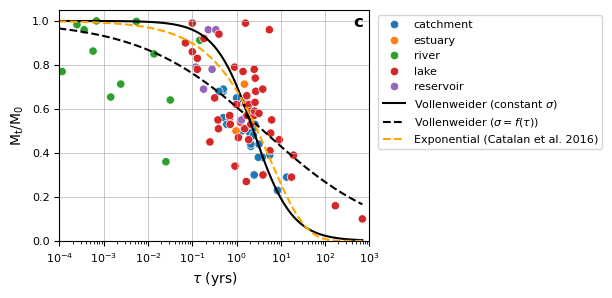

In [32]:
# Plot all models on one plot

fig, ax = plt.subplots(figsize=(4, 3))

# Plot observations
sns.scatterplot(data=df, x='tau', y='mo_mi', hue='Type') 

# # Plot each model's fit
# tau_values = np.linspace(df['tau'].min(), df['tau'].max(), 100000)
tau_values = np.logspace(np.log10(df['tau'].min()), np.log10(df['tau'].max()), 1000)
ax.plot(tau_values, voll_fit1.eval(tau=tau_values), label=r'Vollenweider (constant $\sigma$)', color='k')
# ax.plot(tau_values, exp_fit1.eval(tau=tau_values), label='Exponential (constant $k$)', color='red')
ax.plot(tau_values, voll_fit2.eval(tau=tau_values), ls='--', label=r'Vollenweider ($\sigma = f(\tau$))', color='k')
# ax.plot(tau_values, exp_fit2.eval(tau=tau_values), ls='--', label=r'Exponential ($k = f(\tau$))', color='red')

# Also plot implied results of Catalan's regression, when rearranged for Cout/Cin
trans_catalan = np.exp(-0.38 * tau_values ** 0.55)
ax.plot(tau_values, trans_catalan, ls='--', label="Exponential (Catalan et al. 2016)", color='orange')

plt.ylim(0, 1.05)
plt.xlim(0.0001, 1000)
plt.xscale('log')

plt.grid(True, which='major', linewidth=0.5)

# Add labels and legend
plt.ylabel('$\mathrm{M_t/M_0}$', size=10)
plt.xlabel((r'$\tau$ (yrs)'), size=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
ax.legend(fontsize=8, bbox_to_anchor=(1.01, 1))

# Add the plot location label in bold text to the top right corner
plt.text(0.98, 0.98, 'c', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='top')

plt.savefig(r'graphs/trans-vs-tau_all-data.png', bbox_inches='tight')

# Show plot
plt.show()